In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import train_simple_network, Flatten, weight_reset

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

/tmp/ipykernel_25269/3982418224.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [3]:
torch.backends.cudnn.deterministic=True
from idlmam import set_seed, moveTo
set_seed(42)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

import requests, zipfile, io
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
#z = zipfile.ZipFile('data.zip')
z.extractall()

#Zip file is organized as data/names/[LANG].txt , where [LANG] is a specific language

In [6]:
namge_language_data = {}

#We will use some code to remove UNICODE tokens to make life easy for us processing wise
#e.g., convert something like "Ślusàrski" to Slusarski
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#Loop through every language, open the zip file entry, and read all the lines from the text file.
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [unicodeToAscii(line).lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names)) #Print out the name of each language too.

Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


### Modify LanguageNameDataset so the vocabulary object in the constructor does not need to be passed in as an argument but instead can be inferred from the input dataset. This means you need to iterate through the dataset and create a dictionary with all the characters actually seen. One way to implement this is to create a default value vocabulary=None and use is vocabulary None: to change behavior.

In [7]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i

print(alphabet)
print(''.join([x for x in alphabet.keys()]))
print(''.join(list(alphabet.keys())))
print(all_letters)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, 'Z': 51, ' ': 52, '.': 53, ',': 54, ';': 55, "'": 56}
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


In [8]:
class LanguageNameDataset(Dataset):

    def __init__(self, lang_name_dict, vocabulary=None):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)

        if vocabulary is None:
            self.vocabulary = {}
            all_letters = []
            for elem in self.data:
                for letter in elem:
                    if letter not in all_letters:
                        all_letters.append(letter)
            for i in range(len(all_letters)):
                self.vocabulary[all_letters[i]] = i
        else:
            self.vocabulary = vocabulary

    def __len__(self):
        return len(self.data)

    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object.
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?

        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]

        return name_vec

    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]

        #Conver the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)

        return self.string2InputVec(name), label

In [9]:
dataset = LanguageNameDataset(namge_language_data)
print(dataset[0])

(tensor([0, 1, 2, 3, 4, 5]), 0)


### Update LanguageNameDataset with a flag in the constructor for unicode=False. Change any of the code you need to so that when unicode=True, Language-NameDataset instead keeps all the Unicode characters seen when vocabulary=None (this depends on exercise 1). Train a new RNN classifier with unicode=True. How does it impact the results?

In [10]:
class LanguageNameDataset(Dataset):

    def __init__(self, lang_name_dict, vocabulary=None, unicode=False):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.all_letters = []

        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                if unicode is False:
                    # apply unicodeToAscii
                    sample = [''.join(c for c in unicodedata.normalize('NFD', sample) if unicodedata.category(c) != 'Mn' and c in ''.join(self.label_names))]

                self.data.append(sample)
                self.labels.append(y)

        if vocabulary is None:
            self.vocabulary = {}
            self.all_letters = []
            for elem in self.data:
                for letter in elem:
                    if letter not in self.all_letters:
                        self.all_letters.append(letter)
            for i in range(len(self.all_letters)):
                self.vocabulary[self.all_letters[i]] = i
        else:
            self.vocabulary = vocabulary

    def __len__(self):
        return len(self.data)

    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object.
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?

        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]

        return name_vec

    # def getallletters(self):
    #     return self.all_letters

    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]

        #Conver the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)

        return self.string2InputVec(name), label

In [11]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step
    following
    the output of a PyTorch RNN module.
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
    def forward(self, input):
        rnn_output = input[0]

        last_step = input[1]

        if(type(last_step) == tuple):
            last_step = last_step[0]
        batch_size = last_step.shape[1]

        last_step = last_step.view(self.rnn_layers, self.num_directions, batch_size, -1)

        last_step = last_step[self.rnn_layers-1]

        last_step = last_step.permute(1, 0, 2)

        return last_step.reshape(batch_size, -1)

In [12]:
# prepare data
namge_language_data = {}

for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [line.lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names))

dataset_ascii = LanguageNameDataset(namge_language_data)
dataset_unicode = LanguageNameDataset(namge_language_data, unicode=True)

Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


In [13]:
train_data_ascii, test_data_ascii = torch.utils.data.random_split(dataset_ascii, (len(dataset_ascii)-300, 300))
train_loader_ascii = DataLoader(train_data_ascii, batch_size=1, shuffle=True)
test_loader_ascii = DataLoader(test_data_ascii, batch_size=1, shuffle=False)

train_data_unicode, test_data_unicode = torch.utils.data.random_split(dataset_unicode, (len(dataset_unicode)-300, 300))
train_loader_unicode = DataLoader(train_data_unicode, batch_size=1, shuffle=True)
test_loader_unicode = DataLoader(test_data_unicode, batch_size=1, shuffle=False)

In [14]:
D = 64
vocab_size_ascii = len(dataset_ascii.all_letters)
hidden_nodes = 256
classes = len(dataset_ascii.label_names)

first_rnn_ascii = nn.Sequential(
    nn.Embedding(vocab_size_ascii, D), #(B, T) -> (B, T, D)
    nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
    #the tanh activation is built into the RNN object, so we don't need to do it here
    LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
    nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

D = 64
vocab_size_unicode = len(dataset_unicode.all_letters)
hidden_nodes = 256
classes = len(dataset_unicode.label_names)

first_rnn_unicode = nn.Sequential(
    nn.Embedding(vocab_size_unicode, D), #(B, T) -> (B, T, D)
    nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
    #the tanh activation is built into the RNN object, so we don't need to do it here
    LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
    nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

In [15]:
loss_func = nn.CrossEntropyLoss()

batch_one_train_ascii = train_simple_network(first_rnn_ascii, loss_func, train_loader_ascii, test_loader=test_loader_ascii, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

batch_one_train_unicode = train_simple_network(first_rnn_unicode, loss_func, train_loader_unicode, test_loader=test_loader_unicode, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

KeyboardInterrupt: 

<Axes: xlabel='epoch', ylabel='test Accuracy'>

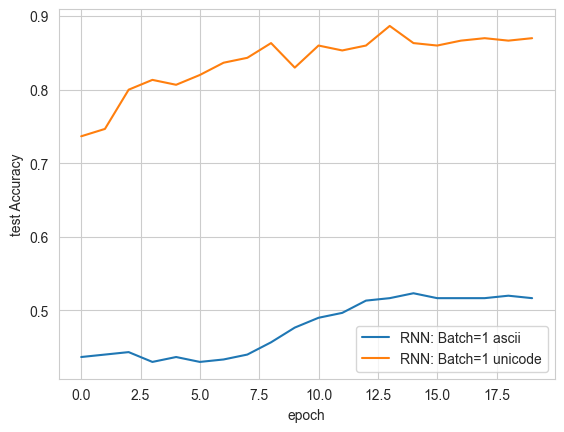

In [17]:
sns.lineplot(x='epoch', y='test Accuracy', data=batch_one_train_ascii, label='RNN: Batch=1 ascii')
sns.lineplot(x='epoch', y='test Accuracy', data=batch_one_train_unicode, label='RNN: Batch=1 unicode')

unicode performes better than ascii :)

### Update LanguageNameDataset with a new min_count=1 argument in the constructor. If vocabulary=None, it should replace any character that occurs too few times with a special "UNK" token, indicating an unknown value. How is the size of the vocabulary impacted by setting in_count=300, and what happens to the results?

In [7]:
class LanguageNameDataset(Dataset):

    def __init__(self, lang_name_dict, vocabulary=None, unicode=False, min_count=1):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.all_letters = []

        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                if unicode is False:
                    # apply unicodeToAscii
                    sample = [''.join(c for c in unicodedata.normalize('NFD', sample) if unicodedata.category(c) != 'Mn' and c in ''.join(self.label_names))]

                self.data.append(sample)
                self.labels.append(y)

        if vocabulary is None:
            self.vocabulary = {}
            self.all_letters = []

            for elem in self.data:
                for letter in elem:
                    l = len([[ix, iy] for ix, row in enumerate(self.all_letters) for iy, el in enumerate(row) if el == letter])
                    if l == 0:
                        self.all_letters.append([letter,1])
                    else:
                        idx = [[ix, iy] for ix,row in enumerate(self.all_letters) for iy, el in enumerate(row) if el==letter][0][0]
                        self.all_letters[idx][1] = self.all_letters[idx][1]+1

            self.all_letters = [row[0] for ix,row in enumerate(self.all_letters) if row[1] > min_count]
            for i in range(len(self.all_letters)):
                self.vocabulary[self.all_letters[i]] = i
            self.vocabulary['UNK'] = len(self.all_letters)
        else:
            self.vocabulary = vocabulary

    def __len__(self):
        return len(self.data)

    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object.
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?

        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            if character in self.vocabulary:
                name_vec[pos] = self.vocabulary[character]
            else:
                name_vec[pos] = len(self.all_letters)

        return name_vec

    # def getallletters(self):
    #     return self.all_letters

    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]

        #Conver the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)

        return self.string2InputVec(name), label

In [8]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step
    following
    the output of a PyTorch RNN module.
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
    def forward(self, input):
        rnn_output = input[0]

        last_step = input[1]

        if(type(last_step) == tuple):
            last_step = last_step[0]
        batch_size = last_step.shape[1]

        last_step = last_step.view(self.rnn_layers, self.num_directions, batch_size, -1)

        last_step = last_step[self.rnn_layers-1]

        last_step = last_step.permute(1, 0, 2)

        return last_step.reshape(batch_size, -1)

In [ ]:
# # prepare data
# name_language_data_utf = {}
#
# for zip_path in z.namelist():
#     if "data/names/" in zip_path and zip_path.endswith(".txt"):
#         lang = zip_path[len("data/names/"):-len(".txt")]
#         with z.open(zip_path) as myfile:
#             language_names = [line.lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
#             name_language_data_utf[lang] = language_names

In [9]:
dataset_unicode = LanguageNameDataset(namge_language_data, vocabulary=None, unicode=True, min_count=300)

In [10]:
print(dataset_unicode.vocabulary)
print(dataset_unicode.all_letters)

{'k': 0, 'h': 1, 'o': 2, 'u': 3, 'r': 4, 'y': 5, 'n': 6, 'a': 7, 's': 8, 'd': 9, 'e': 10, 'g': 11, 'z': 12, 'i': 13, 'm': 14, 'l': 15, 'f': 16, 'b': 17, 't': 18, 'w': 19, 'j': 20, 'c': 21, 'p': 22, 'v': 23, 'UNK': 24}
['k', 'h', 'o', 'u', 'r', 'y', 'n', 'a', 's', 'd', 'e', 'g', 'z', 'i', 'm', 'l', 'f', 'b', 't', 'w', 'j', 'c', 'p', 'v']


In [11]:
D = 64
vocab_size_unicode = len(dataset_unicode.all_letters)+1 # because UNK was added
hidden_nodes = 256
classes = len(dataset_unicode.label_names)

second_rnn_unicode = nn.Sequential(
    nn.Embedding(vocab_size_unicode, D), #(B, T) -> (B, T, D)
    nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
    #the tanh activation is built into the RNN object, so we don't need to do it here
    LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
    nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

In [12]:
train_data_unicode, test_data_unicode = torch.utils.data.random_split(dataset_unicode, (len(dataset_unicode)-300, 300))
train_loader_unicode = DataLoader(train_data_unicode, batch_size=1, shuffle=True)
test_loader_unicode = DataLoader(test_data_unicode, batch_size=1, shuffle=False)

In [13]:
loss_func = nn.CrossEntropyLoss()

batch2_one_train_unicode = train_simple_network(second_rnn_unicode, loss_func, train_loader_unicode, test_loader=test_loader_unicode, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

Training: 100%|█████████▉| 19735/19774 [00:40<00:00, 594.54it/s]
                                                                
Training: 100%|█████████▉| 19723/19774 [00:35<00:00, 552.75it/s]
                                                                
Training: 100%|█████████▉| 19772/19774 [00:26<00:00, 819.93it/s]
                                                                
Training: 100%|█████████▉| 19767/19774 [00:27<00:00, 779.78it/s]
                                                                
Training: 100%|█████████▉| 19736/19774 [00:26<00:00, 815.21it/s]
                                                                
Training: 100%|█████████▉| 19702/19774 [00:26<00:00, 808.37it/s]
                                                                
Training: 100%|█████████▉| 19703/19774 [00:26<00:00, 670.84it/s]
                                                                
Training: 100%|█████████▉| 19771/19774 [00:26<00:00, 779.25it/s]
                         

<Axes: xlabel='epoch', ylabel='test Accuracy'>

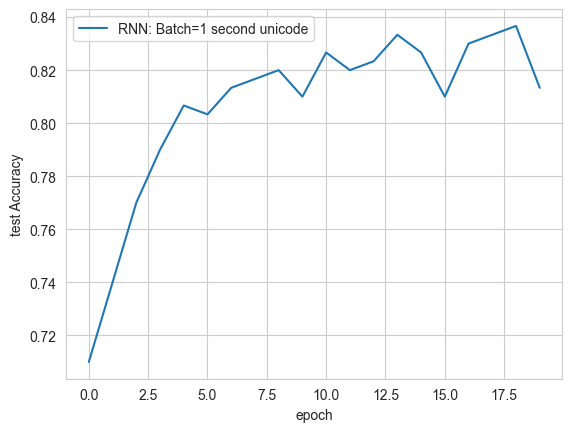

In [14]:
sns.lineplot(x='epoch', y='test Accuracy', data=batch2_one_train_unicode, label='RNN: Batch=1 second unicode')

Seems to be similar to our first examples (on gpu) on cpu a bit worse

### The original training/test split for this task was created by randomly sampling the dataset. Create your own function that performs stratified splitting: selecting a test set that has the same proportions of each class. How does this impact your apparent results?

In [9]:
#https://gist.github.com/Alvtron/9b9c2f870df6a54fda24dbd1affdc254

import random
import math
import torch.utils.data
from collections import defaultdict

def stratified_split(dataset : torch.utils.data.Dataset, labels, fraction, random_state=None):
    if random_state: random.seed(random_state)
    indices_per_label = defaultdict(list)
    for index, label in enumerate(labels):
        indices_per_label[label].append(index)
    first_set_indices, second_set_indices = list(), list()
    for label, indices in indices_per_label.items():
        n_samples_for_label = round(len(indices) * fraction)
        random_indices_sample = random.sample(indices, n_samples_for_label)
        first_set_indices.extend(random_indices_sample)
        second_set_indices.extend(set(indices) - set(random_indices_sample))
    first_set_inputs = torch.utils.data.Subset(dataset, first_set_indices)
    first_set_labels = list(map(labels.__getitem__, first_set_indices))
    second_set_inputs = torch.utils.data.Subset(dataset, second_set_indices)
    second_set_labels = list(map(labels.__getitem__, second_set_indices))
    return first_set_inputs, first_set_labels, second_set_inputs, second_set_labels

In [10]:
# prepare data
namge_language_data = {}

for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [line.lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names))

Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


In [11]:
dataset_unicode = LanguageNameDataset(namge_language_data, vocabulary=None, unicode=True, min_count=300)
# split dataset into training-, testing- and validation set
#train_data, train_labels, test_data, _ = stratified_split(dataset_unicode, dataset_unicode.labels, fraction=0.9, random_state=1)
# train_data, train_labels, eval_data, _ = stratified_split(train_data, train_labels, fraction=0.9, random_state=1)

In [12]:
D = 64
vocab_size_unicode = len(dataset_unicode.all_letters)+1 # because UNK was added
hidden_nodes = 256
classes = len(dataset_unicode.label_names)

third_rnn_unicode = nn.Sequential(
    nn.Embedding(vocab_size_unicode, D), #(B, T) -> (B, T, D)
    nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
    #the tanh activation is built into the RNN object, so we don't need to do it here
    LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
    nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

In [13]:
# train_data_unicode, test_data_unicode = torch.utils.data.random_split(dataset_unicode, (len(dataset_unicode)-300, 300))
train_data_unicode, _, test_data_unicode, _ = stratified_split(dataset_unicode, dataset_unicode.labels, fraction=0.9, random_state=1)
train_loader_unicode = DataLoader(train_data_unicode, batch_size=1, shuffle=True)
test_loader_unicode = DataLoader(test_data_unicode, batch_size=1, shuffle=False)

In [14]:
loss_func = nn.CrossEntropyLoss()

batch3_one_train_unicode = train_simple_network(third_rnn_unicode, loss_func, train_loader_unicode, test_loader=test_loader_unicode, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/18067 [00:00<?, ?it/s]

Testing:   0%|          | 0/2007 [00:00<?, ?it/s]

Training:   0%|          | 0/18067 [00:00<?, ?it/s]

Testing:   0%|          | 0/2007 [00:00<?, ?it/s]

Training:   0%|          | 0/18067 [00:00<?, ?it/s]

Testing:   0%|          | 0/2007 [00:00<?, ?it/s]

Training:   0%|          | 0/18067 [00:00<?, ?it/s]

Testing:   0%|          | 0/2007 [00:00<?, ?it/s]

Training:   0%|          | 0/18067 [00:00<?, ?it/s]

Testing:   0%|          | 0/2007 [00:00<?, ?it/s]

Training:   0%|          | 0/18067 [00:00<?, ?it/s]

Testing:   0%|          | 0/2007 [00:00<?, ?it/s]

Training:   0%|          | 0/18067 [00:00<?, ?it/s]

Testing:   0%|          | 0/2007 [00:00<?, ?it/s]

Training:   0%|          | 0/18067 [00:00<?, ?it/s]

Testing:   0%|          | 0/2007 [00:00<?, ?it/s]

Training:   0%|          | 0/18067 [00:00<?, ?it/s]

Testing:   0%|          | 0/2007 [00:00<?, ?it/s]

Training:   0%|          | 0/18067 [00:00<?, ?it/s]

Testing:   0%|          | 0/2007 [00:00<?, ?it/s]

Training:   0%|          | 0/18067 [00:00<?, ?it/s]

Testing:   0%|          | 0/2007 [00:00<?, ?it/s]

Training:   0%|          | 0/18067 [00:00<?, ?it/s]

Testing:   0%|          | 0/2007 [00:00<?, ?it/s]

Training:   0%|          | 0/18067 [00:00<?, ?it/s]

Testing:   0%|          | 0/2007 [00:00<?, ?it/s]

Training:   0%|          | 0/18067 [00:00<?, ?it/s]

Testing:   0%|          | 0/2007 [00:00<?, ?it/s]

Training:   0%|          | 0/18067 [00:00<?, ?it/s]

Testing:   0%|          | 0/2007 [00:00<?, ?it/s]

Training:   0%|          | 0/18067 [00:00<?, ?it/s]

Testing:   0%|          | 0/2007 [00:00<?, ?it/s]

Training:   0%|          | 0/18067 [00:00<?, ?it/s]

Testing:   0%|          | 0/2007 [00:00<?, ?it/s]

Training:   0%|          | 0/18067 [00:00<?, ?it/s]

Testing:   0%|          | 0/2007 [00:00<?, ?it/s]

Training:   0%|          | 0/18067 [00:00<?, ?it/s]

Testing:   0%|          | 0/2007 [00:00<?, ?it/s]

Training:   0%|          | 0/18067 [00:00<?, ?it/s]

Testing:   0%|          | 0/2007 [00:00<?, ?it/s]

<AxesSubplot: xlabel='epoch', ylabel='test Accuracy'>

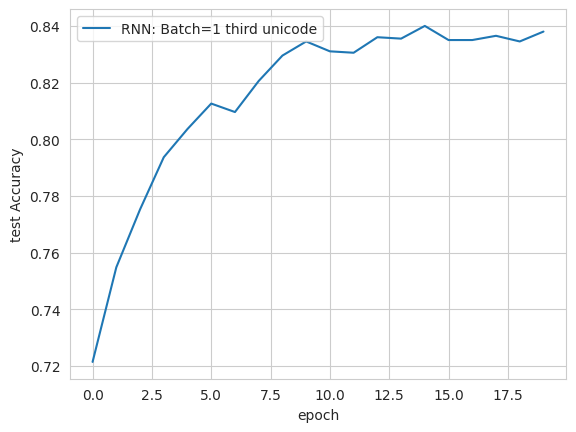

In [15]:
sns.lineplot(x='epoch', y='test Accuracy', data=batch3_one_train_unicode, label='RNN: Batch=1 third unicode')

performs a little better

### Replace the last output layer nn.Linear(hidden_nodes, classes) from the RNN implementation with a fully connected network with two hidden layers and one output layer. How does this impact the accuracy of the model?

In [7]:
# prepare data
namge_language_data = {}

for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [line.lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names))

Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


In [8]:
class LanguageNameDataset(Dataset):

    def __init__(self, lang_name_dict, vocabulary=None, unicode=False):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.all_letters = []

        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                if unicode is False:
                    # apply unicodeToAscii
                    sample = [''.join(c for c in unicodedata.normalize('NFD', sample) if unicodedata.category(c) != 'Mn' and c in ''.join(self.label_names))]

                self.data.append(sample)
                self.labels.append(y)

        if vocabulary is None:
            self.vocabulary = {}
            self.all_letters = []
            for elem in self.data:
                for letter in elem:
                    if letter not in self.all_letters:
                        self.all_letters.append(letter)
            for i in range(len(self.all_letters)):
                self.vocabulary[self.all_letters[i]] = i
        else:
            self.vocabulary = vocabulary

    def __len__(self):
        return len(self.data)

    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object.
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?

        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]

        return name_vec

    # def getallletters(self):
    #     return self.all_letters

    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]

        #Conver the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)

        return self.string2InputVec(name), label

In [9]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step
    following
    the output of a PyTorch RNN module.
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
    def forward(self, input):
        rnn_output = input[0]

        last_step = input[1]

        if(type(last_step) == tuple):
            last_step = last_step[0]
        batch_size = last_step.shape[1]

        last_step = last_step.view(self.rnn_layers, self.num_directions, batch_size, -1)

        last_step = last_step[self.rnn_layers-1]

        last_step = last_step.permute(1, 0, 2)

        return last_step.reshape(batch_size, -1)

In [10]:
dataset_unicode = LanguageNameDataset(namge_language_data, vocabulary=None)

In [11]:
D = 64
vocab_size_unicode = len(dataset_unicode.all_letters)
hidden_nodes = 256
classes = len(dataset_unicode.label_names)

fourth_rnn_unicode = nn.Sequential(
    nn.Embedding(vocab_size_unicode, D), #(B, T) -> (B, T, D)
    nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
    #the tanh activation is built into the RNN object, so we don't need to do it here
    LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
    nn.Linear(hidden_nodes, hidden_nodes), #(B,D) -> (B,D)
    nn.Tanh(),
    nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

In [12]:
train_data_unicode, test_data_unicode = torch.utils.data.random_split(dataset_unicode, (len(dataset_unicode)-300, 300))
train_loader_unicode = DataLoader(train_data_unicode, batch_size=1, shuffle=True)
test_loader_unicode = DataLoader(test_data_unicode, batch_size=1, shuffle=False)

In [13]:
loss_func = nn.CrossEntropyLoss()

batch4_one_train_unicode = train_simple_network(fourth_rnn_unicode, loss_func, train_loader_unicode, test_loader=test_loader_unicode, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

<AxesSubplot: xlabel='epoch', ylabel='test Accuracy'>

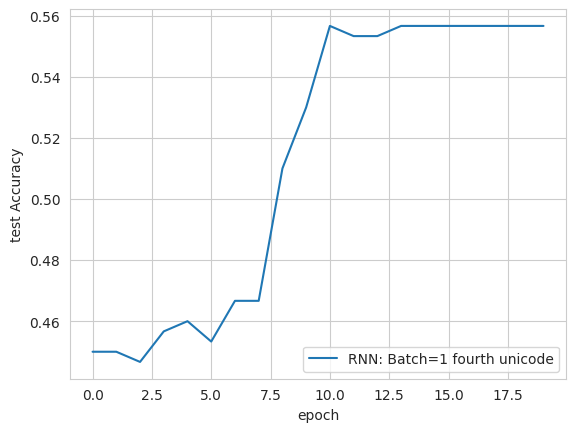

In [14]:
sns.lineplot(x='epoch', y='test Accuracy', data=batch4_one_train_unicode, label='RNN: Batch=1 fourth unicode')

mhh seems to be not really usable

### You can use the collation function to implement interesting features. To get a better handle on how it works, implement your own collate_fn that removes half the items from a batch of training data. Does training with two epochs of this model obtain the same results as training with one epoch of a normal collate_fn? Why or why not?

In [7]:
def reduce_input(batch):

    tensor_data, tensor_label = [], []
    for td, tl in batch:
        tensor_data.append(torch.split(td,2)[0])
        tensor_label.append(tl)

    inputs = torch.nn.utils.rnn.pad_sequence(tensor_data, batch_first=False)
    labels = torch.tensor(tensor_label)

    return inputs, labels

# prepare data
namge_language_data = {}

for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [line.lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names))

Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


In [8]:
class LanguageNameDataset(Dataset):

    def __init__(self, lang_name_dict, vocabulary=None, unicode=False):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.all_letters = []

        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                if unicode is False:
                    # apply unicodeToAscii
                    sample = [''.join(c for c in unicodedata.normalize('NFD', sample) if unicodedata.category(c) != 'Mn' and c in ''.join(self.label_names))]

                self.data.append(sample)
                self.labels.append(y)

        if vocabulary is None:
            self.vocabulary = {}
            self.all_letters = []
            for elem in self.data:
                for letter in elem:
                    if letter not in self.all_letters:
                        self.all_letters.append(letter)
            for i in range(len(self.all_letters)):
                self.vocabulary[self.all_letters[i]] = i
        else:
            self.vocabulary = vocabulary

    def __len__(self):
        return len(self.data)

    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object.
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?

        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]

        return name_vec

    # def getallletters(self):
    #     return self.all_letters

    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]

        #Conver the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)

        return self.string2InputVec(name), label

In [9]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step
    following
    the output of a PyTorch RNN module.
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
    def forward(self, input):
        rnn_output = input[0]

        last_step = input[1]

        if(type(last_step) == tuple):
            last_step = last_step[0]
        batch_size = last_step.shape[1]

        last_step = last_step.view(self.rnn_layers, self.num_directions, batch_size, -1)

        last_step = last_step[self.rnn_layers-1]

        last_step = last_step.permute(1, 0, 2)

        return last_step.reshape(batch_size, -1)

In [10]:
dataset_unicode = LanguageNameDataset(namge_language_data, vocabulary=None, unicode=True)

In [11]:
D = 64
vocab_size_unicode = len(dataset_unicode.all_letters)+1 # because UNK was added
hidden_nodes = 256
classes = len(dataset_unicode.label_names)

sixed_rnn_unicode = nn.Sequential(
    nn.Embedding(vocab_size_unicode, D), #(B, T) -> (B, T, D)
    nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
    #the tanh activation is built into the RNN object, so we don't need to do it here
    LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
    nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

In [12]:
train_data_unicode, test_data_unicode = torch.utils.data.random_split(dataset_unicode, (len(dataset_unicode)-300, 300))
collate_train_loader_unicode = DataLoader(train_data_unicode, batch_size=2, shuffle=True, collate_fn=reduce_input)
collate_test_loader_unicode = DataLoader(test_data_unicode, batch_size=2, shuffle=False, collate_fn=reduce_input)

In [13]:
loss_func = nn.CrossEntropyLoss()

batch_collate_train_unicode = train_simple_network(sixed_rnn_unicode, loss_func, train_loader=collate_train_loader_unicode, test_loader=collate_test_loader_unicode, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=2)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/9887 [00:00<?, ?it/s]

Testing:   0%|          | 0/150 [00:00<?, ?it/s]

Training:   0%|          | 0/9887 [00:00<?, ?it/s]

Testing:   0%|          | 0/150 [00:00<?, ?it/s]

In [17]:
train_loader_unicode = DataLoader(train_data_unicode, batch_size=1, shuffle=True)
test_loader_unicode = DataLoader(test_data_unicode, batch_size=1, shuffle=False)

In [18]:
batch_sixed_train_unicode = train_simple_network(sixed_rnn_unicode, loss_func, train_loader=train_loader_unicode, test_loader=test_loader_unicode, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=1)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

<AxesSubplot: xlabel='epoch', ylabel='test Accuracy'>

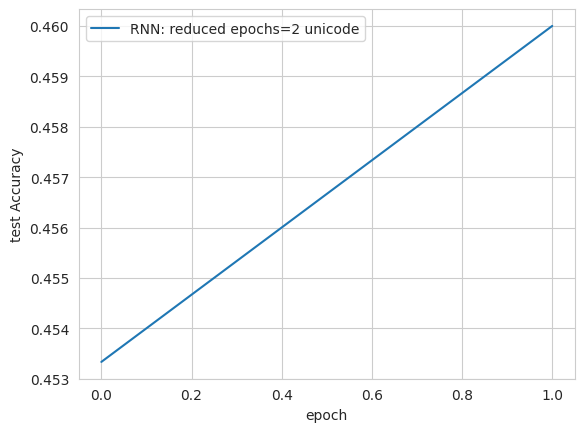

In [19]:
sns.lineplot(x='epoch', y='test Accuracy', data=batch_collate_train_unicode, label='RNN: reduced epochs=2 unicode')

<AxesSubplot: xlabel='epoch', ylabel='test Accuracy'>

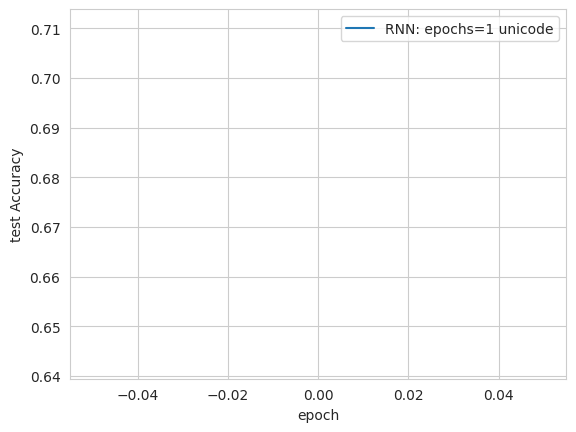

In [20]:
sns.lineplot(x='epoch', y='test Accuracy', data=batch_sixed_train_unicode, label='RNN: epochs=1 unicode')

seems like training with a smaller batch for two epochs performs better than one training with full batch

### Compare training a three-layer bidirectional RNN with batch sizes of B = {1, 2, 4, 8} for five epochs. Which batch size seems to give the best balance between speed and accuracy?

In [7]:
def norm_input(batch):

    tensor_data, tensor_label = [], []
    for td, tl in batch:
        tensor_data.append(td)
        tensor_label.append(tl)

    inputs = torch.nn.utils.rnn.pad_sequence(tensor_data, batch_first=False)
    inputs_padded = torch.nn.utils.rnn.pack_padded_sequence(inputs, [i.shape[0] for i in tensor_data],enforce_sorted=False, batch_first=False)
    labels = torch.tensor(tensor_label)

    return inputs_padded, labels

for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [line.lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names))

Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


In [8]:
class LanguageNameDataset(Dataset):

    def __init__(self, lang_name_dict, vocabulary=None, unicode=False):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.all_letters = []

        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                if unicode is False:
                    # apply unicodeToAscii
                    sample = [''.join(c for c in unicodedata.normalize('NFD', sample) if unicodedata.category(c) != 'Mn' and c in ''.join(self.label_names))]

                self.data.append(sample)
                self.labels.append(y)

        if vocabulary is None:
            self.vocabulary = {}
            self.all_letters = []
            for elem in self.data:
                for letter in elem:
                    if letter not in self.all_letters:
                        self.all_letters.append(letter)
            for i in range(len(self.all_letters)):
                self.vocabulary[self.all_letters[i]] = i
        else:
            self.vocabulary = vocabulary

    def __len__(self):
        return len(self.data)

    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object.
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?

        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]

        return name_vec

    # def getallletters(self):
    #     return self.all_letters

    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]

        #Conver the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)

        return self.string2InputVec(name), label

In [9]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step
    following
    the output of a PyTorch RNN module.
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
    def forward(self, input):
        rnn_output = input[0]

        last_step = input[1]

        if(type(last_step) == tuple):
            last_step = last_step[0]
        batch_size = last_step.shape[1]

        last_step = last_step.view(self.rnn_layers, self.num_directions, batch_size, -1)

        last_step = last_step[self.rnn_layers-1]

        last_step = last_step.permute(1, 0, 2)

        return last_step.reshape(batch_size, -1)

In [10]:
dataset_unicode = LanguageNameDataset(namge_language_data, vocabulary=None, unicode=True)

In [11]:
from idlmam import EmbeddingPackable

D = 64
vocab_size_unicode = len(dataset_unicode.vocabulary) # because UNK was added
hidden_nodes = 256 #linear --> (= 256 * 2) due to bi-directional
classes = len(dataset_unicode.label_names)

bi_rnn_unicode = nn.Sequential(
    EmbeddingPackable(nn.Embedding(vocab_size_unicode, D)), #(B, T) -> (B, T, D)
    nn.RNN(D, hidden_nodes, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
    #the tanh activation is built into the RNN object, so we don't need to do it here
    LastTimeStep(bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
    nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

In [12]:
loss_func = nn.CrossEntropyLoss()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/20074 [00:00<?, ?it/s]

Testing:   0%|          | 0/20074 [00:00<?, ?it/s]

Training:   0%|          | 0/20074 [00:00<?, ?it/s]

Testing:   0%|          | 0/20074 [00:00<?, ?it/s]

Training:   0%|          | 0/20074 [00:00<?, ?it/s]

Testing:   0%|          | 0/20074 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/10037 [00:00<?, ?it/s]

Testing:   0%|          | 0/10037 [00:00<?, ?it/s]

Training:   0%|          | 0/10037 [00:00<?, ?it/s]

Testing:   0%|          | 0/10037 [00:00<?, ?it/s]

Training:   0%|          | 0/10037 [00:00<?, ?it/s]

Testing:   0%|          | 0/10037 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

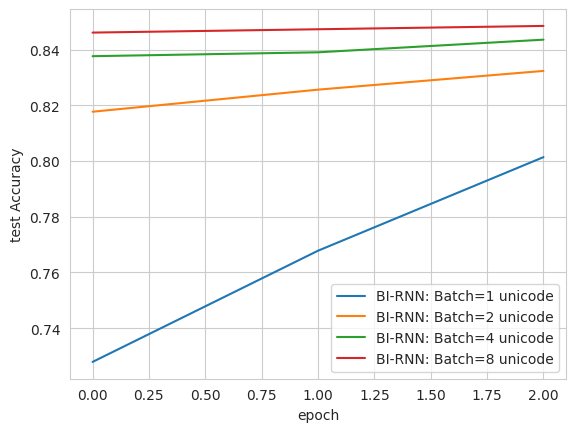

In [13]:
batch_size = [1,2,4,8]
for bs in batch_size:
    train_loader_unicode = DataLoader(dataset_unicode, batch_size=bs, collate_fn=norm_input, shuffle=True)
    test_loader_unicode = DataLoader(dataset_unicode, batch_size=bs, collate_fn=norm_input, shuffle=False)

    batch_x_train_unicode = train_simple_network(bi_rnn_unicode, loss_func, train_loader=train_loader_unicode, test_loader=test_loader_unicode, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=3)

    sns.lineplot(x='epoch', y='test Accuracy', data=batch_x_train_unicode, label='BI-RNN: Batch='+str(bs)+' unicode')

higher batch impacts better accuracy but slower improvement (it should be tested on more than just 3 epochs). training gets also faster based on network training time